
# Tarea 2 Ejercicio 3
#### Basada en el notebook:
## Reconocimiento de acciones humanas usando RNNs 

Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).


---
---

En esta libreta compararemos el desempeño de dos modelos para reconocimiento de acciones humanas (HAR) en el conjunto [UCF11](https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php).

<img src="https://www.crcv.ucf.edu/data/youtube_snaps.jpg" width=800/>

El primer modelo está basado en las ideas presentadas en [*Long-term Recurrent Convolutional Networks for Visual Recognition and Description*](https://arxiv.org/abs/1411.4389) de 2016 por Donahue et al. 

## 1 Preparación

### 1.1 Bibliotecas

In [2]:
# Colab
# https://github.com/TylerYep/torchinfo
!pip install torchinfo
# https://zarr.readthedocs.io/en/stable/
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 31.3 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=e0aae029c01638e968efd64796554e4a5560f0966dce703fc14083c9dcf2d6bb
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree


In [24]:
# sistema de archivos
import os
# funciones aleatorias
import random
# descomprimir
import tarfile
# sistema de archivos
from os.path import join

# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
# almacenamiento de arreglos multidimensionales
import zarr
#redes
from torch.utils.data import DataLoader, random_split
# inspección de arquitectura
from torchinfo import summary
# gráficas
import matplotlib.pyplot as plt

# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch_gen = torch.manual_seed(SEED)

## 2 Datos

### 2.1 Conjunto de datos

In [4]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)
    
    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

### 2.2 Instancia del conjunto y partición

In [5]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

  0%|          | 0/53436566 [00:00<?, ?it/s]

x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


In [6]:
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

### 2.3 Cargadores de datos

In [7]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)

In [8]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## 3 Modelo

<!-- Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes.  -->

### 3.1 Definición de arquitecturas

El primer modelo es una RNN bidireccional con una capa GRU, y el segundo una arquitectura CNN con una capa Conv1d.

In [34]:
class RNN(nn.Module):

    def __init__(self, input_size=1024, hidden_size=128, num_classes=11):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=1, batch_first=True)
        self.cls = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Batch, Seq, Feats, Hidden
        # [B, S, F] => [B, F, S]
        x = x.movedim(1, 2)
        # [B, F, S]
        x = self.bn(x)
        # [B, F, S] => [B, S, F]
        x = x.movedim(1, 2)
        # [B, S, F] => [B, S, H]
        x, _ = self.rnn(x)
        # [B, S, H] => [B, H]
        x = x[:, -1, :]
        # [B, H] = [B, 11]
        x = self.cls(x)
        return x



class CNN(nn.Module):
    # input_size=1024, hidden_size=128, num_classes=11
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 128
        
        # definición de bloques conv
        # [N, 10, 1024] => [N, 4, 14, 14]
        self.cnn = nn.Sequential(
            # bloque conv1
            # [N, 1, 10, 1024] => [N, 1, 4, 512]
            nn.Conv1d(in_channels=10, out_channels=4, kernel_size=2, stride=2, padding=1),
            # [N, 1, 4, 512]
            nn.ReLU(),
            # [N, 1, 4, 512] => [N, 1, 4, 32]
            nn.MaxPool2d(kernel_size=4, stride=4),
        )
        
        # [N, 1, 4, 32] => [N, 1x4x32=128]
        self.flatten = nn.Flatten()

        # [N, 128] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 11)
    
    # metodo para inferencia
    def forward(self, x):
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        x = self.flatten(x)
        x = self.cls(x)
        return x
  

In [17]:
model1 = RNN().eval()
print("model 1 logits")
print(model1(torch.zeros(1, 10, 1024)).shape)
print("model 2 logits")
model2 = CNN().eval()
model2(torch.zeros(1, 10, 1024)).shape

model 1 logits
torch.Size([1, 11])
model 2 logits


torch.Size([1, 11])

### 3.2 Inspección de arquitecturas

In [32]:
summary(model1, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 128]              443,136
├─Linear: 1-3                            [1, 11]                   1,419
Total params: 446,603
Trainable params: 446,603
Non-trainable params: 0
Total mult-adds (M): 4.43
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 1.79
Estimated Total Size (MB): 1.92

In [35]:
summary(model2, (1, 10, 1024), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─Sequential: 1-1                        [1, 1, 128]               --
│    └─Conv1d: 2-1                       [1, 4, 513]               84
│    └─ReLU: 2-2                         [1, 4, 513]               --
│    └─MaxPool2d: 2-3                    [1, 1, 128]               --
├─Flatten: 1-2                           [1, 128]                  --
├─Linear: 1-3                            [1, 11]                   1,419
Total params: 1,503
Trainable params: 1,503
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.04
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

## 4 Entrenamiento

### 4.1 Ciclo de entrenamiento

In [31]:
# optimizador
opt1 = optim.Adam(model1.parameters(), lr=1e-3)
opt2 = optim.Adam(model2.parameters(), lr=1e-3)

loss_m1 = []
loss_m2 = []
acc_m1 = []
acc_m2 = []

EPOCHS = 50

# ciclo de entrenamiento del primer modelo
model = model1
opt =  opt1
print("Ciclo de entrenamiento del modelo 1 (RNN)")
for epoch in range(EPOCHS):

    # modelo en modo de entrenamiento
    model.train()
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # desactivamos temporalmente la gráfica de cómputo
    with torch.no_grad():

        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in tst_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        loss_m1.append(loss)
        acc_m1.append(acc)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')

# ciclo de entrenamiento del segundo modelo
model = model2
opt =  opt2
print("Ciclo de entrenamiento del modelo 2 (CNN)")
for epoch in range(EPOCHS):

    # modelo en modo de entrenamiento
    model.train()
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # desactivamos temporalmente la gráfica de cómputo
    with torch.no_grad():

        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in tst_dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        loss_m2.append(loss)
        acc_m2.append(acc)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')

Ciclo de entrenamiento del modelo 1 (RNN)
E 0 loss=181.59 acc=54.69
E 1 loss=184.28 acc=55.62
E 2 loss=190.09 acc=54.38
E 3 loss=185.91 acc=56.25
E 4 loss=185.40 acc=58.12
E 5 loss=190.36 acc=55.00
E 6 loss=194.06 acc=56.25
E 7 loss=191.44 acc=58.12
E 8 loss=188.93 acc=57.50
E 9 loss=189.54 acc=54.06
E10 loss=195.73 acc=57.19
E11 loss=201.56 acc=54.69
E12 loss=203.78 acc=54.69
E13 loss=204.10 acc=53.44
E14 loss=204.81 acc=51.25
E15 loss=200.33 acc=51.56
E16 loss=202.38 acc=55.94
E17 loss=202.15 acc=54.06
E18 loss=199.45 acc=52.81
E19 loss=204.90 acc=53.75
E20 loss=205.12 acc=55.94
E21 loss=204.47 acc=55.94
E22 loss=206.00 acc=55.00
E23 loss=207.99 acc=53.44
E24 loss=206.29 acc=56.56
E25 loss=207.81 acc=55.00
E26 loss=210.17 acc=54.69
E27 loss=211.64 acc=53.75
E28 loss=210.69 acc=55.62
E29 loss=210.21 acc=55.31
E30 loss=207.37 acc=55.62
E31 loss=211.43 acc=54.69
E32 loss=211.09 acc=55.31
E33 loss=213.53 acc=56.25
E34 loss=211.96 acc=55.31
E35 loss=215.51 acc=54.06
E36 loss=214.53 acc=54

## 4.2 Gráficas de pérdida y precisión



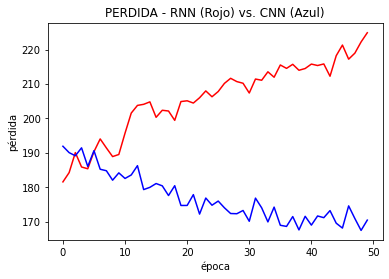

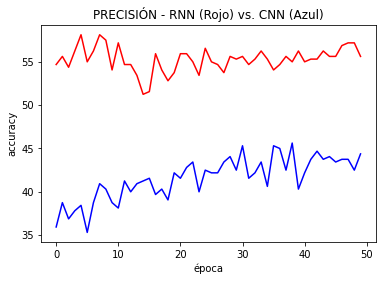

In [33]:
plt.plot(loss_m1, color='red')
plt.xlabel('época')
plt.title("PERDIDA - RNN (Rojo) vs. CNN (Azul)")
plt.ylabel('pérdida')
plt.plot(loss_m2, color='blue')
plt.show()

plt.clf()
plt.plot(acc_m1, color='red')
plt.xlabel('época')
plt.title("PRECISIÓN - RNN (Rojo) vs. CNN (Azul)")
plt.ylabel('accuracy')
#plt.show()

#plt.close()
plt.plot(acc_m2, color='blue')
plt.show()

## 5. Conclusión

Se implementaron dos modelos sencillos, el primero una RNN bidireccional con una capa GRU, y el segundo una arquitectura CNN con una capa Conv1d. Ambos se entrenaron para la tarea de reconocimiento de acciones humanas sobre el mismo conjunto de datos UCF11. 

Las gráficas anteriores comparan los valores de pérdida y precisión de ambos modelos durante 50 épocas de entrenamiento. Vemos que en todo momento el valor de accuracy de la Red Neuronal Recurrente (RNN) es mejor que el de la Convolucional (CNN). Pero esto puede deberse al tamaño de los modelos -- intenté que ambas redes tuvieran un tamaño equivalente pero creo que la GRU terminó ocupando más parámetros que la arquitectura convolucional.
